In [1]:
import psycopg2
import pandas as pd
from getpass import getpass
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

np.random.seed(13)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
user = getpass()
password = getpass()
ip = getpass()
port = getpass()
dbname = getpass()

········
········
········
········
········


In [3]:
db_connection_string = 'postgresql://{}:{}@{}:{}/{}'

with psycopg2.connect(db_connection_string.format(user,
                                                  password,
                                                  ip,
                                                  port,
                                                  dbname)) as con:

    sql = """SELECT chess_games.game_link,
                    chess_games.player_color,
                    chess_games.player_elo,
                    chess_games.opponent_elo,
                    chess_games.player_elo - chess_games.opponent_elo as elo_diff,
                    game_clocks.half_move,
                    fen,
                    increment,
                    (increment > 0)::int as has_increment,
                    result,
                    evaluation,
                    clock
             from game_clocks
             -- tablesample bernoulli(1.5) repeatable(13)
             JOIN chess_games on chess_games.game_link = game_clocks.game_link
             LEFT JOIN game_evals on game_evals.game_link = game_clocks.game_link
                  and game_evals.half_move = game_clocks.half_move
             WHERE
                 -- evaluation not in (-9999, 9999) and
                 time_control_category in ('blitz')
             and chess_games.player_elo > 2800
             --ORDER BY chess_games.game_link asc, game_clocks.half_move asc
             ;
             """

    df = pd.read_sql_query(sql, con)

In [4]:
df.to_csv('_wp.csv', index=False)

In [5]:
df = pd.read_csv('_wp.csv')

In [6]:
df.head()

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock
0,https://lichess.org/fHe99o7o,white,2885.0,2958.0,-73.0,7,rnbqkb1r/ppp2ppp/5n2/3pp3/4PP2/2N5/PPPP2PP/R1B...,2,1,0-1,-0.26,183
1,https://lichess.org/lV5KsinX,white,2817.0,2733.0,84.0,68,8/4k2p/1p4p1/p2Bn3/P4P2/1P2K3/7P/8 b - - 0,0,0,1-0,-0.97,29
2,https://lichess.org/lV5KsinX,white,2817.0,2733.0,84.0,125,7Q/8/8/p5K1/8/1k6/p7/8 w - - 0,0,0,1-0,59.70,7
3,https://lichess.org/E4orrp1E,white,2814.0,2641.0,173.0,26,r3k2r/pp2n1b1/nqp1p1pp/3pP3/3P4/2P2N2/PP2QPP1/...,0,0,1-0,0.64,140
4,https://lichess.org/E4orrp1E,white,2814.0,2641.0,173.0,40,4k2r/pp2n1b1/4p1pp/3pP3/1q6/2N5/P2BQPP1/R3K2R ...,0,0,1-0,5.67,83


In [7]:
df.shape

(16031, 12)

In [8]:
df = df[df['evaluation'].notna()]

In [9]:
# filter out where we don't have clock times
df = df[df['clock'] != -1]

In [10]:
df['result_points'] = (df['result'] == '1-0') + (df['result'] == '1/2-1/2') * 0.5
df['evaluation_binned'] = (df['evaluation'] / 3).round(decimals=0) * 3

In [11]:
df.sort_values(by=['game_link', 'half_move'], ascending=True, inplace=True)

In [12]:
df.head(10)

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned
7159,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,1,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,0,0-1,0.86,90,0.0,0.0
12591,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,2,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,0,0,0-1,0.41,90,0.0,0.0
14271,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,3,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,0,0,0-1,0.23,89,0.0,0.0
5386,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,4,rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQK...,0,0,0-1,0.38,90,0.0,0.0
7490,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,5,rnbqkbnr/pp2pppp/3p4/2p5/4P3/5N2/PPPP1PPP/RNBQ...,0,0,0-1,0.32,87,0.0,0.0
5734,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,6,rnbqkbnr/pp2pppp/3p4/1Bp5/4P3/5N2/PPPP1PPP/RNB...,0,0,0-1,0.51,89,0.0,0.0
380,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,7,r1bqkbnr/pp1npppp/3p4/1Bp5/4P3/5N2/PPPP1PPP/RN...,0,0,0-1,0.18,87,0.0,0.0
8084,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,8,r1bqkbnr/pp1npppp/3p4/1Bp5/3PP3/5N2/PPP2PPP/RN...,0,0,0-1,0.07,89,0.0,0.0
1014,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,9,r1bqkbnr/pp1npppp/3p4/1B6/3pP3/5N2/PPP2PPP/RNB...,0,0,0-1,0.19,87,0.0,0.0
5105,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,10,r1bqkbnr/pp1npppp/3p4/1B6/3QP3/5N2/PPP2PPP/RNB...,0,0,0-1,0.14,89,0.0,0.0


In [13]:
df['opponent_clock'] = df.groupby(['game_link'])['clock'].shift(-1)
df['opponent_clock'].fillna(df['opponent_clock'].shift(2), inplace=True)
df[df['game_link'] == 'https://lichess.org/00LWUMCJ'].tail(10)

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock


In [14]:
df['opponent_clock'].isna().sum()

0

In [15]:
df[df['opponent_clock'].isna()].head(5)

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock


In [16]:
df[df['game_link'].isin(df[df['opponent_clock'].isna()]['game_link'])].groupby('game_link')['result'].count()

Series([], Name: result, dtype: int64)

In [17]:
df[df['game_link'] == 'https://lichess.org/2cB0u5Zl']

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock


In [18]:
# in situations where there were only one or two moves, fill with the clock time
df['opponent_clock'].fillna(df['clock'], inplace=True)

In [19]:
df['opponent_clock'].isna().sum()

0

In [20]:
df['white_to_move'] = df['half_move'] % 2

In [21]:
initial_times = df.groupby(['game_link', 'white_to_move'])[['game_link', 'white_to_move', 'clock']].head(1)
initial_times.columns = ['game_link', 'white_to_move', 'initial_clock']
df = pd.merge(df, initial_times, on=['game_link', 'white_to_move'], how='inner')
# flip bit for opponent's time to move
initial_times['white_to_move'] = (initial_times['white_to_move'] + 1) % 2
initial_times.columns = ['game_link', 'white_to_move', 'opponent_initial_clock']
df = pd.merge(df, initial_times, on=['game_link', 'white_to_move'], how='inner')

In [22]:
df[df['game_link'] == 'https://lichess.org/00LWUMCJ'].tail(10)

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock,white_to_move,initial_clock,opponent_initial_clock


In [23]:
# set min time to 1, max time to initial time
df['clock_pct'] = np.maximum(1, np.minimum(df['initial_clock'], df['clock'])) / df['initial_clock']
df['sig_clock_pct'] = np.log(df['clock_pct'] / (1.00001 - df['clock_pct']))
df['opponent_clock_pct'] = np.maximum(1, np.minimum(df['opponent_initial_clock'],
                                                    df['opponent_clock'])) / df['opponent_initial_clock']
df['opponent_sig_clock_pct'] = np.log(df['opponent_clock_pct'] / (1.00001 - df['opponent_clock_pct']))
df.head()

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock,white_to_move,initial_clock,opponent_initial_clock,clock_pct,sig_clock_pct,opponent_clock_pct,opponent_sig_clock_pct
0,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,1,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,0,0-1,0.86,90,0.0,0.0,90.0,1,90,90,1.000000,11.512925,1.000000,11.512925
1,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,3,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,0,0,0-1,0.23,89,0.0,0.0,90.0,1,90,90,0.988889,4.487737,1.000000,11.512925
2,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,5,rnbqkbnr/pp2pppp/3p4/2p5/4P3/5N2/PPPP1PPP/RNBQ...,0,0,0-1,0.32,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737
3,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,7,r1bqkbnr/pp1npppp/3p4/1Bp5/4P3/5N2/PPPP1PPP/RN...,0,0,0-1,0.18,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737
4,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,194.0,9,r1bqkbnr/pp1npppp/3p4/1B6/3pP3/5N2/PPP2PPP/RNB...,0,0,0-1,0.19,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737


In [24]:
# drop situations where clock time is way above original time
df.dropna(subset=['sig_clock_pct', 'opponent_sig_clock_pct'], inplace=True)

<AxesSubplot:>

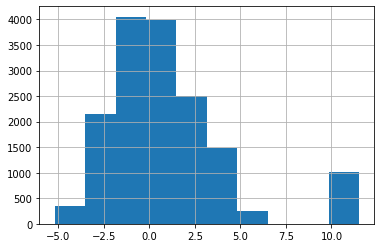

In [25]:
df['sig_clock_pct'].hist()

In [26]:
df['sig_clock_pct'].describe()

count    15773.000000
mean         1.014506
std          3.445024
min         -5.187396
25%         -1.189597
50%          0.336448
75%          2.260431
max         11.512925
Name: sig_clock_pct, dtype: float64

<AxesSubplot:>

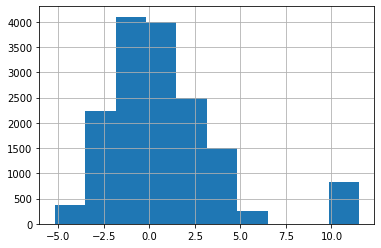

In [27]:
df['opponent_sig_clock_pct'].hist()

In [28]:
df['evaluation_binned'].max(), df['evaluation_binned'].min()

(75.0, -75.0)

In [29]:
grouped = df.groupby(['evaluation_binned'], as_index=False).agg({'result_points': 'mean'})

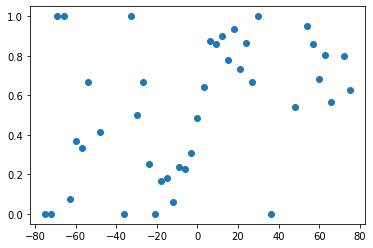

In [30]:
plt.scatter(grouped['evaluation_binned'], grouped['result_points'])

In [31]:
df['player_color_mapped'] = df['player_color'].map({'black': 1, 'white': 0})
df['white_clock'] = df['player_color_mapped'] * df['opponent_clock'] + (1 - df['player_color_mapped']) * df['clock']
df['black_clock'] = df['player_color_mapped'] * df['clock'] + (1 - df['player_color_mapped']) * df['opponent_clock']

df['white_clock_pct'] = df['player_color_mapped'] * df['opponent_clock_pct'] + (1 - df['player_color_mapped']) * df['clock_pct']
df['black_clock_pct'] = df['player_color_mapped'] * df['clock_pct'] + (1 - df['player_color_mapped']) * df['opponent_clock_pct']

df['white_sig_clock_pct'] = (df['player_color_mapped'] * df['opponent_sig_clock_pct']
                             + (1 - df['player_color_mapped']) * df['sig_clock_pct'])
df['black_sig_clock_pct'] = (df['player_color_mapped'] * df['sig_clock_pct']
                             + (1 - df['player_color_mapped']) * df['opponent_sig_clock_pct'])

In [32]:
df['white_elo'] = df['player_color_mapped'] * df['opponent_elo'] + (1 - df['player_color_mapped']) * df['player_elo']
df['black_elo'] = df['player_color_mapped'] * df['player_elo'] + (1 - df['player_color_mapped']) * df['opponent_elo']
df['elo_diff'] = df['white_elo'] - df['black_elo']

In [33]:
df.head()

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,fen,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock,white_to_move,initial_clock,opponent_initial_clock,clock_pct,sig_clock_pct,opponent_clock_pct,opponent_sig_clock_pct,player_color_mapped,white_clock,black_clock,white_clock_pct,black_clock_pct,white_sig_clock_pct,black_sig_clock_pct,white_elo,black_elo
0,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,-194.0,1,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,0,0-1,0.86,90,0.0,0.0,90.0,1,90,90,1.000000,11.512925,1.000000,11.512925,1,90.0,90.0,1.000000,1.000000,11.512925,11.512925,2618.0,2812.0
1,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,-194.0,3,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,0,0,0-1,0.23,89,0.0,0.0,90.0,1,90,90,0.988889,4.487737,1.000000,11.512925,1,90.0,89.0,1.000000,0.988889,11.512925,4.487737,2618.0,2812.0
2,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,-194.0,5,rnbqkbnr/pp2pppp/3p4/2p5/4P3/5N2/PPPP1PPP/RNBQ...,0,0,0-1,0.32,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737,1,89.0,87.0,0.988889,0.966667,4.487737,3.366996,2618.0,2812.0
3,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,-194.0,7,r1bqkbnr/pp1npppp/3p4/1Bp5/4P3/5N2/PPPP1PPP/RN...,0,0,0-1,0.18,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737,1,89.0,87.0,0.988889,0.966667,4.487737,3.366996,2618.0,2812.0
4,https://lichess.org/03Pqx7ld,black,2812.0,2618.0,-194.0,9,r1bqkbnr/pp1npppp/3p4/1B6/3pP3/5N2/PPP2PPP/RNB...,0,0,0-1,0.19,87,0.0,0.0,89.0,1,90,90,0.966667,3.366996,0.988889,4.487737,1,89.0,87.0,0.988889,0.966667,4.487737,3.366996,2618.0,2812.0


In [34]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['result_points', 'result']),
                                                    df['result_points'], test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=13)

x_train.shape, x_val.shape, x_test.shape

((9463, 29), (3155, 29), (3155, 29))

Pre-outlier removal size: (9463, 29)
Post-outlier removal size: (7705, 29)


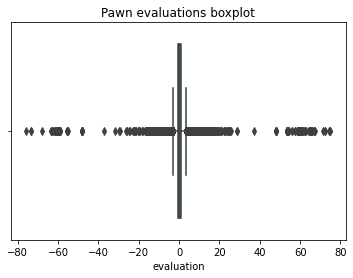

In [35]:
sns.boxplot(x=x_train['evaluation'])
plt.title('Pawn evaluations boxplot')

p25 = np.percentile(x_train['evaluation'], 25)
p75 = np.percentile(x_train['evaluation'], 75)
iqr = p75 - p25

print(f'Pre-outlier removal size: {x_train.shape}')
y_train = y_train[x_train['evaluation'] > p25 - 1.5 * iqr]
y_train = y_train[x_train['evaluation'] < p75 + 1.5 * iqr]
x_train = x_train[x_train['evaluation'] > p25 - 1.5 * iqr]
x_train = x_train[x_train['evaluation'] < p75 + 1.5 * iqr]
print(f'Post-outlier removal size: {x_train.shape}')

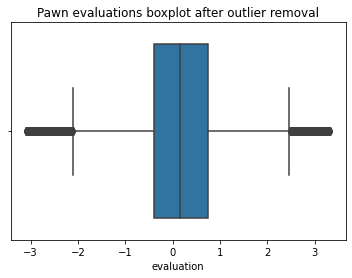

In [36]:
plt.title('Pawn evaluations boxplot after outlier removal')
sns.boxplot(x=x_train['evaluation']);

In [37]:
x_train.columns

Index(['game_link', 'player_color', 'player_elo', 'opponent_elo', 'elo_diff',
       'half_move', 'fen', 'increment', 'has_increment', 'evaluation', 'clock',
       'evaluation_binned', 'opponent_clock', 'white_to_move', 'initial_clock',
       'opponent_initial_clock', 'clock_pct', 'sig_clock_pct',
       'opponent_clock_pct', 'opponent_sig_clock_pct', 'player_color_mapped',
       'white_clock', 'black_clock', 'white_clock_pct', 'black_clock_pct',
       'white_sig_clock_pct', 'black_sig_clock_pct', 'white_elo', 'black_elo'],
      dtype='object')

In [38]:
# shoutout stackoverflow
def brier_multi(targets, probs):
    return ((probs - targets) ** 2).sum(axis=1).mean()

In [40]:
cols = ['elo_diff', 'evaluation', 'white_sig_clock_pct', 'black_sig_clock_pct', 'has_increment']

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=13, C=1, n_jobs=-1, multi_class='multinomial')

lr.fit(x_train[cols], y_train.astype(str))
preds_lr = lr.predict_proba(x_val[cols])

In [42]:
lr.classes_

array(['0.0', '0.5', '1.0'], dtype=object)

In [43]:
y_val_ohe = np.array([y_val == 0, y_val == 0.5, y_val == 1.0]).astype(int).T
uniform = np.ones(preds_lr.shape) / 3

In [44]:
brier_multi(y_val_ohe, preds_lr)

0.49840833080260283

In [45]:
brier_multi(y_val_ohe, uniform)

0.6666666666666669

In [46]:
lr.intercept_

array([ 0.3913176 , -0.73280501,  0.3414874 ])

In [47]:
lr.coef_

array([[-2.82435172e-03, -2.52244537e-01,  2.44078977e-02,
         5.17737083e-02, -5.15945779e-01],
       [-2.95574010e-04,  5.11139272e-02, -6.77099415e-02,
        -3.65168757e-02,  9.66993471e-01],
       [ 3.11992573e-03,  2.01130610e-01,  4.33020439e-02,
        -1.52568326e-02, -4.51047692e-01]])

In [48]:
import statsmodels.formula.api as sm
from sklearn.metrics import brier_score_loss

# cols = ['elo_diff', 'evaluation', 'white_sig_clock_pct', 'black_sig_clock_pct', 'has_increment']
# cols = ['elo_diff', 'evaluation', 'clock', 'has_increment']

model = sm.logit(f'result_points ~ {" + ".join(cols)}',
                 pd.concat([x_train[cols], (y_train > 0.5).astype(int)], axis=1))
result = model.fit()
display(result.summary())

predictions_train = result.predict(x_train[cols])
predictions = result.predict(x_val[cols])
brier_score_loss(y_val > 0.5, predictions)

Optimization terminated successfully.
         Current function value: 0.565176
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          result_points   No. Observations:                 7705
Model:                          Logit   Df Residuals:                     7699
Method:                           MLE   Df Model:                            5
Date:                Sat, 18 Sep 2021   Pseudo R-squ.:                  0.1635
Time:                        09:59:49   Log-Likelihood:                -4354.7
converged:                       True   LL-Null:                       -5205.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4928      0.030    -16.275      0.000      -0.552      -0.433
elo_diff                0.0054      0.000     31.256      0.000       0.005       0.006
evaluation              0.3159      0.023     13.617      0.000       0.270       0.361
white_sig_clock_pct     0.0336      0.015      2.238      0.025       0.004       0.063
black_sig_clock_pct    -0.0119      0.015     -0.791      0.429      -0.041       0.018
has_increment          -0.6056      0.072     -8.438      0.000      -0.746      -0.465
=======================================================================================
"""

0.19272450223715237

# notes

- intercept is negative because predicting p(white wins), which excludes draws
- higher ratings are more predictable
- clock coefs make sense with higher ratings
- increment coef is negative because increases draw probability

In [49]:
test = pd.DataFrame([[0, 0, 1, 1, 0]],
                    columns=['elo_diff', 'evaluation', 'white_sig_clock_pct', 'black_sig_clock_pct', 'has_increment'])

result.predict(test)

0    0.38434
dtype: float64

In [50]:
lr.predict_proba(test), (lr.predict_proba(test) @ [0, 0.5, 1]).item()

(array([[0.45914127, 0.1245649 , 0.41629383]]), 0.47857628268666197)

In [51]:
df['result_points'].value_counts(normalize=True)

0.0    0.428200
1.0    0.421797
0.5    0.150003
Name: result_points, dtype: float64

In [52]:
from sklearn.metrics import roc_auc_score, log_loss

print(f'AUC: {roc_auc_score(y_val > 0.5, predictions):.4f}')
print(f'Log loss: {log_loss(y_val > 0.5, predictions):.4f}')

AUC: 0.7654
Log loss: 0.6505


<AxesSubplot:>

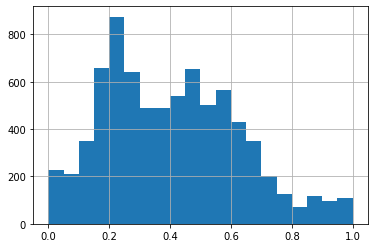

In [53]:
predictions_train.hist(bins=20)

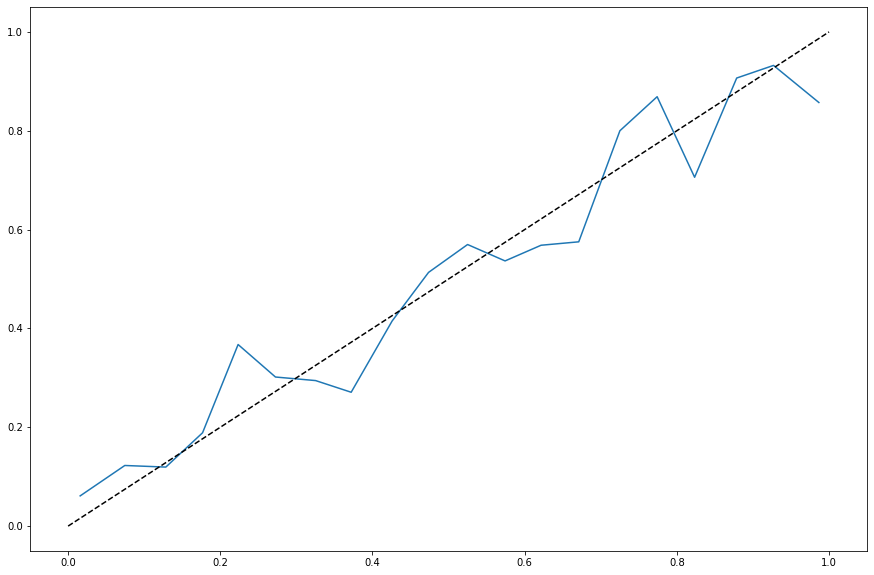

In [54]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(15, 10))

prob_true, prob_pred = calibration_curve(y_val > 0.5, predictions, n_bins=20)
plt.plot(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], 'k--');

In [55]:
x_train[predictions_train > 0.7].describe().T

,count,mean,std,min,25%,50%,75%,max
player_elo,722.0,2843.645429,44.124261,2801.000000,2810.000000,2837.000000,2851.000000,2954.000000
opponent_elo,722.0,2420.027701,285.141135,1546.000000,2278.000000,2498.000000,2627.000000,2824.000000
elo_diff,722.0,423.617729,268.059065,102.000000,208.000000,343.000000,553.000000,1291.000000
half_move,722.0,31.685596,22.379579,1.000000,14.000000,29.000000,43.000000,114.000000
increment,722.0,0.398892,0.799722,0.000000,0.000000,0.000000,0.000000,2.000000
has_increment,722.0,0.199446,0.399861,0.000000,0.000000,0.000000,0.000000,1.000000
evaluation,722.0,0.745568,1.231966,-3.100000,0.072500,0.690000,1.600000,3.330000
clock,722.0,126.650970,50.402789,8.000000,85.000000,142.000000,173.000000,192.000000
evaluation_binned,722.0,0.706371,1.507149,-3.000000,0.000000,0.000000,3.000000,3.000000
opponent_clock,722.0,125.459834,50.442059,8.000000,86.250000,139.000000,171.000000,192.000000


In [56]:
x_train[predictions_train <= 0.7].describe().T

,count,mean,std,min,25%,50%,75%,max
player_elo,6983.0,2871.136045,45.585797,2801.000000,2824.000000,2872.000000,2907.000000,2957.000000
opponent_elo,6983.0,2751.474724,140.461652,1415.000000,2705.000000,2756.000000,2835.000000,2973.000000
elo_diff,6983.0,-29.360876,173.003259,-1422.000000,-130.000000,-18.000000,100.000000,343.000000
half_move,6983.0,45.853501,34.042034,1.000000,19.000000,39.000000,65.000000,201.000000
increment,6983.0,0.361736,0.769872,0.000000,0.000000,0.000000,0.000000,2.000000
has_increment,6983.0,0.180868,0.384936,0.000000,0.000000,0.000000,0.000000,1.000000
evaluation,6983.0,0.083130,1.148150,-3.100000,-0.430000,0.130000,0.690000,3.330000
clock,6983.0,99.758413,59.124254,0.000000,47.000000,93.000000,160.000000,203.000000
evaluation_binned,6983.0,-0.025777,1.301199,-3.000000,0.000000,0.000000,0.000000,3.000000
opponent_clock,6983.0,98.358585,58.703970,0.000000,46.000000,90.000000,159.000000,203.000000


In [57]:
(df.loc[predictions_train[predictions_train < 0.1].index]
   .sort_values(by='evaluation', ascending=False)
   .drop(columns=['fen'])
   .head(10))

,game_link,player_color,player_elo,opponent_elo,elo_diff,half_move,increment,has_increment,result,evaluation,clock,result_points,evaluation_binned,opponent_clock,white_to_move,initial_clock,opponent_initial_clock,clock_pct,sig_clock_pct,opponent_clock_pct,opponent_sig_clock_pct,player_color_mapped,white_clock,black_clock,white_clock_pct,black_clock_pct,white_sig_clock_pct,black_sig_clock_pct,white_elo,black_elo
13398,https://lichess.org/qnpiiMz4,black,2839.0,2373.0,-466.0,10,2,1,0-1,3.16,185,0.0,3.0,172.0,0,180,180,1.000000,11.512925,0.955556,3.067828,1,172.0,185.0,0.955556,1.000000,3.067828,11.512925,2373.0,2839.0
9049,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,69,0,0,0-1,2.76,62,0.0,3.0,53.0,1,180,90,0.344444,-0.643565,0.588889,0.359350,1,53.0,62.0,0.588889,0.344444,0.359350,-0.643565,2318.0,2803.0
9050,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,71,0,0,0-1,2.62,58,0.0,3.0,51.0,1,180,90,0.322222,-0.743593,0.566667,0.268241,1,51.0,58.0,0.566667,0.322222,0.268241,-0.743593,2318.0,2803.0
9102,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,66,0,0,0-1,2.42,57,0.0,3.0,63.0,0,90,180,0.633333,0.546516,0.350000,-0.619055,1,63.0,57.0,0.350000,0.633333,-0.619055,0.546516,2318.0,2803.0
12072,https://lichess.org/krlMhTdP,black,2838.0,2236.0,-602.0,5,2,1,0-1,2.37,181,0.0,3.0,184.0,1,180,180,1.000000,11.512925,1.000000,11.512925,1,184.0,181.0,1.000000,1.000000,11.512925,11.512925,2236.0,2838.0
12073,https://lichess.org/krlMhTdP,black,2838.0,2236.0,-602.0,7,2,1,0-1,2.31,182,0.0,3.0,185.0,1,180,180,1.000000,11.512925,1.000000,11.512925,1,185.0,182.0,1.000000,1.000000,11.512925,11.512925,2236.0,2838.0
9048,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,67,0,0,0-1,2.25,63,0.0,3.0,55.0,1,180,90,0.350000,-0.619055,0.611111,0.451959,1,55.0,63.0,0.611111,0.350000,0.451959,-0.619055,2318.0,2803.0
9101,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,64,0,0,0-1,2.23,61,0.0,3.0,68.0,0,90,180,0.677778,0.743547,0.377778,-0.499007,1,68.0,61.0,0.377778,0.677778,-0.499007,0.743547,2318.0,2803.0
9053,https://lichess.org/XAX6paa4,black,2803.0,2318.0,-485.0,77,0,0,0-1,2.23,54,0.0,3.0,45.0,1,180,90,0.300000,-0.847312,0.500000,-0.000020,1,45.0,54.0,0.500000,0.300000,-0.000020,-0.847312,2318.0,2803.0
13708,https://lichess.org/sENX7fY4,black,2837.0,1415.0,-1422.0,9,2,1,0-1,2.18,163,0.0,3.0,180.0,1,180,180,0.905556,2.260431,1.000000,11.512925,1,180.0,163.0,1.000000,0.905556,11.512925,2.260431,1415.0,2837.0


In [59]:
predictions_train.iloc[243]

0.3481614803307462

In [60]:
df.loc[predictions_train[predictions_train > 0.7].index]['result_points'].mean()

0.8587257617728532

Suspicion: "clock" can represent either clock, and the model doesn't have both pieces of information (on what each player's clock looks like)

In [ ]:
# TODO: create indices on game_link, half_move

In [ ]:
# pace of play as per train model on winner clock times to predict percentage of time remaining as a function of move number -KB